# Imports

In [86]:
import numpy as np
import pandas as pd
import re
from string import punctuation
import emoji

In [87]:
import nltk
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN, GRU
# from tensorflow.keras.pipeline import pi

In [88]:
import matplotlib.pyplot as plt

In [89]:
nltk.download("punkt_tab")
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\artem\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\artem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Vars definition

In [90]:
n_gram = 3
window_size = 5

In [91]:
stop_words = set(stopwords.words("english"))
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

# Data preparation

## Initial clean

In [92]:
df = pd.read_csv("data/data.csv")
df

,product_name,overall_rating,no_ratings,no_reviews,rating,title,review
0,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,"15,210",900,5,Perfect product!,"Loved it, it's my first MacBook that I earned ..."
1,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,"15,210",900,5,Fabulous!,Battery lasted longer than my first relationsh...
2,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,"15,210",900,5,Fabulous!,Such a great deal.. very happy with the perfor...
3,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,"15,210",900,4,Delightful,"Awesome build quality and very good display, b..."
4,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,"15,210",900,5,Awesome,When i ordered and came to know about seller r...
...,...,...,...,...,...,...,...
24108,MSI Modern 14 Intel Core i5 13th Gen 1335U - (...,4.3,156,24,5,Perfect product!,MSI Laptop is high performance and the best. c...
24109,MSI Modern 14 Intel Core i5 13th Gen 1335U - (...,4.3,156,24,5,Perfect product!,Excellent performance best laptop.
24110,MSI Modern 14 Intel Core i5 13th Gen 1335U - (...,4.3,156,24,4,"Good product, Lacks features.",Decent battery life. Exceptional build quality...
24111,Lenovo IdeaPad 5 2-in-1 WUXGA IPS AMD Ryzen 7 ...,4.4,7,2,3,Nice,The product does not support facial recognitio...


In [93]:
df_review = df[["review"]]
df_review

,review
0,"Loved it, it's my first MacBook that I earned ..."
1,Battery lasted longer than my first relationsh...
2,Such a great deal.. very happy with the perfor...
3,"Awesome build quality and very good display, b..."
4,When i ordered and came to know about seller r...
...,...
24108,MSI Laptop is high performance and the best. c...
24109,Excellent performance best laptop.
24110,Decent battery life. Exceptional build quality...
24111,The product does not support facial recognitio...


In [94]:
def clean_text_dataframe(
    df_i: pd.DataFrame,
    columns: list[str] | None = None,
    keep_apostrophe: bool = True,
    min_words: int = 3,
) -> pd.DataFrame:
    """
    Очищает текст и удаляет строки с малым количеством слов

    Params:
        df (pd.DataFrame): Исходный DataFrame
        columns (list[str]|None): Столбцы для обработки (None = все строковые)
        keep_apostrophe (bool): Сохранять апострофы (по умолчанию True)
        min_words (int): Минимальное количество слов для сохранения строки

    Return:
        pd.DataFrame: Очищенная и отфильтрованная копия DataFrame
    """
    df_clean = df_i.copy()

    # Определение целевых столбцов
    if columns is None:
        columns = df_clean.select_dtypes(include=["object", "string"]).columns.tolist()

    # Настройка паттерна для пунктуации
    punct_pattern = r"[{}]".format(
        re.escape(
            punctuation.replace("'", "") if keep_apostrophe else re.escape(punctuation)
        )
    )

    def text_cleaner(text):
        if not isinstance(text, str):
            return text

        # Удаление эмодзи
        text = emoji.replace_emoji(text, replace="")

        # Удаление пунктуации
        text = re.sub(punct_pattern, " ", text)

        # Удаление спецсимволов
        text = re.sub(r"[^a-zA-Z0-9\'\s]", " ", text)

        # Нормализация пробелов
        text = re.sub(r"\s+", " ", text).strip()

        return text

    for col in columns:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].apply(text_cleaner)

    word_count_mask = (
        df_clean[columns]
        .apply(lambda col: col.str.split().str.len() > min_words)
        .all(axis=1)
    )

    df_clean = df_clean[word_count_mask].reset_index(drop=True)

    return df_clean

In [95]:
df_review = clean_text_dataframe(df_review, min_words=n_gram)
df_review

,review
0,Loved it it's my first MacBook that I earned f...
1,Battery lasted longer than my first relationsh...
2,Such a great deal very happy with the performa...
3,Awesome build quality and very good display ba...
4,When i ordered and came to know about seller r...
...,...
17232,MSI Laptop is high performance and the best co...
17233,Excellent performance best laptop
17234,Decent battery life Exceptional build quality ...
17235,The product does not support facial recognitio...


## Data tokenize

In [96]:
def tokenize_text_dataframe(df_i: pd.DataFrame, tokenizer):
    return pd.DataFrame(
        df_i.iloc[:, 0].apply(
            lambda col: [
                word for word in tokenizer(col.lower()) if word not in stop_words
            ]
        )
    )

In [97]:
df_tokens = tokenize_text_dataframe(
    df_review, TweetTokenizer(match_phone_numbers=False).tokenize
)
df_tokens

,review
0,"[loved, first, macbook, earned, hardwork]"
1,"[battery, lasted, longer, first, relationship,..."
2,"[great, deal, happy, performance, battery, lif..."
3,"[awesome, build, quality, good, display, batte..."
4,"[ordered, came, know, seller, review, scared, ..."
...,...
17232,"[msi, laptop, high, performance, best, configu..."
17233,"[excellent, performance, best, laptop]"
17234,"[decent, battery, life, exceptional, build, qu..."
17235,"[product, support, facial, recognition, ir, se..."


In [98]:
df_tokens = df_tokens[df_tokens["review"].apply(lambda col: len(col) > n_gram)].reset_index(drop=True)
df_tokens

,review
0,"[loved, first, macbook, earned, hardwork]"
1,"[battery, lasted, longer, first, relationship,..."
2,"[great, deal, happy, performance, battery, lif..."
3,"[awesome, build, quality, good, display, batte..."
4,"[ordered, came, know, seller, review, scared, ..."
...,...
15042,"[msi, laptop, high, performance, best, configu..."
15043,"[excellent, performance, best, laptop]"
15044,"[decent, battery, life, exceptional, build, qu..."
15045,"[product, support, facial, recognition, ir, se..."


In [99]:
def vocab_text_dataframe(df_i: pd.DataFrame):
    return pd.DataFrame(df_i.iloc[:, 0].apply(lambda col: sorted(set(col))))


def idx_text_dataframe(df_i: pd.DataFrame):
    return pd.DataFrame(
        df_i.iloc[:, 0].apply(lambda col: {word: idx for idx, word in enumerate(col)})
    )


def global_idx_text_dataframe(df_i: pd.DataFrame):
    """
    Создаёт словарь {слово: индекс} для всех уникальных слов
    из объединённой первой колонки DataFrame, сохраняя порядок появления слов.
    Возвращает DataFrame с одним словарём в виде строки.
    """
    # Объединяем все элементы из первой колонки в один список
    all_words = sum(df_i.iloc[:, 0].tolist(), [])

    # Удаляем дубликаты с сохранением порядка первого появления
    unique_words = list(set(all_words))

    # Создаём итоговый словарь {слово: индекс}
    combined_dict = {word: idx for idx, word in enumerate(unique_words)}

    return pd.DataFrame(list(combined_dict.items()), columns=["Word", "Index"])

In [100]:
df_vocab = vocab_text_dataframe(df_tokens)
df_word_to_idx = idx_text_dataframe(df_vocab)
df_global_word_to_idx = global_idx_text_dataframe(df_vocab)

In [101]:
df_vocab

,review
0,"[earned, first, hardwork, loved, macbook]"
1,"[1, 2, 5, arijit, battery, communication, days..."
2,"[battery, deal, flipkart, great, happy, life, ..."
3,"[awesome, battery, build, camera, display, goo..."
4,"[5, apple, awesome, came, click, condition, de..."
...,...
15042,"[5, backup, battery, best, better, con, config..."
15043,"[best, excellent, laptop, performance]"
15044,"[battery, build, c, camera, charger, decent, e..."
15045,"[facial, ir, product, recognition, sensor, sup..."


In [102]:
df_word_to_idx

,review
0,"{'earned': 0, 'first': 1, 'hardwork': 2, 'love..."
1,"{'1': 0, '2': 1, '5': 2, 'arijit': 3, 'battery..."
2,"{'battery': 0, 'deal': 1, 'flipkart': 2, 'grea..."
3,"{'awesome': 0, 'battery': 1, 'build': 2, 'came..."
4,"{'5': 0, 'apple': 1, 'awesome': 2, 'came': 3, ..."
...,...
15042,"{'5': 0, 'backup': 1, 'battery': 2, 'best': 3,..."
15043,"{'best': 0, 'excellent': 1, 'laptop': 2, 'perf..."
15044,"{'battery': 0, 'build': 1, 'c': 2, 'camera': 3..."
15045,"{'facial': 0, 'ir': 1, 'product': 2, 'recognit..."


In [103]:
df_global_word_to_idx

,Word,Index
0,circuiy,0
1,claims,1
2,refundable,2
3,47260,3
4,keays,4
...,...,...
7595,19k,7595
7596,hdr,7596
7597,shocked,7597
7598,recharge,7598


In [104]:
tokens = df_tokens.iloc[:, 0].to_list()
vocab = df_vocab.iloc[:, 0].to_list()
global_vocab = list(sorted(set([item for sublist in vocab for item in sublist])))
vocab_size = len(global_vocab)
word_to_idx = df_word_to_idx.iloc[:, 0].to_list()
global_word_to_idx = {
    v: k for k, v in df_global_word_to_idx.iloc[:, 0].to_dict().items()
}

In [105]:

word_to_idx

[{'earned': 0, 'first': 1, 'hardwork': 2, 'loved': 3, 'macbook': 4},
 {'1': 0,
  '2': 1,
  '5': 2,
  'arijit': 3,
  'battery': 4,
  'communication': 5,
  'days': 6,
  'fingerprint': 7,
  'first': 8,
  'full': 9,
  'getting': 10,
  'lasted': 11,
  'listening': 12,
  'lock': 13,
  'longer': 14,
  'nice': 15,
  'opens': 16,
  'relationship': 17,
  'responsive': 18,
  'since': 19,
  'singh': 20,
  'songs': 21,
  'stars': 22,
  'still': 23,
  "there's": 24,
  'touchpad': 25,
  'two': 26,
  'unlike': 27,
  'volume': 28,
  'warmth': 29,
  'way': 30},
 {'battery': 0,
  'deal': 1,
  'flipkart': 2,
  'great': 3,
  'happy': 4,
  'life': 5,
  'origional': 6,
  'performance': 7,
  'product': 8,
  'thank': 9},
 {'awesome': 0,
  'battery': 1,
  'build': 2,
  'camera': 3,
  'display': 4,
  'good': 5,
  'macos': 6,
  'new': 7,
  'quality': 8,
  'still': 9},
 {'5': 0,
  'apple': 1,
  'awesome': 2,
  'came': 3,
  'click': 4,
  'condition': 5,
  'developer': 6,
  'first': 7,
  'fully': 8,
  'genuine': 9,


In [106]:
global_word_to_idx

{'circuiy': 0,
 'claims': 1,
 'refundable': 2,
 '47260': 3,
 'keays': 4,
 'jt': 5,
 'copilot': 6,
 'resolutions': 7,
 'gb': 8,
 'okayish': 9,
 'submitted': 10,
 'project': 11,
 'gtav': 12,
 'branded': 13,
 'nits': 14,
 'consoles': 15,
 'pair': 16,
 'moderately': 17,
 'ribbon': 18,
 'migrated': 19,
 'enhances': 20,
 'work': 21,
 'logistics': 22,
 'aal': 23,
 'emergency': 24,
 'screw': 25,
 'upgarade': 26,
 'abou': 27,
 '45mins': 28,
 'personally': 29,
 'vfx': 30,
 'wobbling': 31,
 '13th': 32,
 '2build': 33,
 'havoc': 34,
 'curious': 35,
 'sunlight': 36,
 'comfortably': 37,
 'proform': 38,
 'usp': 39,
 'rom': 40,
 'sold': 41,
 'buyed': 42,
 'sutter': 43,
 'observation': 44,
 '2days': 45,
 'thrilled': 46,
 'mult': 47,
 'a15': 48,
 'inconvenient': 49,
 'warking': 50,
 'impacts': 51,
 'stoped': 52,
 'anti': 53,
 'heard': 54,
 'runs': 55,
 'chance': 56,
 'browse': 57,
 'sire': 58,
 'connect': 59,
 'extreme': 60,
 'cdr': 61,
 'rebooting': 62,
 'difficulties': 63,
 'logo': 64,
 'noticing': 65,

In [107]:
vocab

[['earned', 'first', 'hardwork', 'loved', 'macbook'],
 ['1',
  '2',
  '5',
  'arijit',
  'battery',
  'communication',
  'days',
  'fingerprint',
  'first',
  'full',
  'getting',
  'lasted',
  'listening',
  'lock',
  'longer',
  'nice',
  'opens',
  'relationship',
  'responsive',
  'since',
  'singh',
  'songs',
  'stars',
  'still',
  "there's",
  'touchpad',
  'two',
  'unlike',
  'volume',
  'warmth',
  'way'],
 ['battery',
  'deal',
  'flipkart',
  'great',
  'happy',
  'life',
  'origional',
  'performance',
  'product',
  'thank'],
 ['awesome',
  'battery',
  'build',
  'camera',
  'display',
  'good',
  'macos',
  'new',
  'quality',
  'still'],
 ['5',
  'apple',
  'awesome',
  'came',
  'click',
  'condition',
  'developer',
  'first',
  'fully',
  'genuine',
  'get',
  'got',
  'great',
  'guess',
  'heating',
  'ide',
  'idea',
  'installed',
  'intellij',
  'issue',
  'know',
  'light',
  'looks',
  'macbook',
  'magic',
  'opening',
  'ordered',
  'original',
  'packagin

In [108]:
global_vocab

["'",
 '0',
 '000',
 '005',
 '01',
 '02',
 '03',
 '03hrs',
 '04',
 '042023',
 '05',
 '06',
 '0630',
 '06hrs',
 '07',
 '08',
 '09',
 '1',
 '10',
 '100',
 '1000',
 '10000',
 '100fps',
 '100gb',
 '100k',
 '100mbps',
 '100s',
 '100srgb',
 '100w',
 '1019u',
 '1024',
 '1050',
 '10500',
 '105w',
 '1080',
 '1080p',
 '10but',
 '10dsys',
 '10gbps',
 '10gen',
 '10hr',
 '10k',
 '10lakh',
 '10m',
 '10mm',
 '10momths',
 '10months',
 '10sec',
 '10th',
 '10x',
 '11',
 '110',
 '1111',
 '111fps',
 '11200h',
 '1125g4',
 '11260h',
 '115w',
 '11a',
 '11gen',
 '11hrs',
 '11k',
 '11pro',
 '11th',
 '12',
 '120',
 '1200',
 '1200mhz',
 '120fps',
 '120hz',
 '120w',
 '1215',
 '1215u',
 '1235u',
 '12450',
 '12450h',
 '12450hx',
 '12500',
 '12500h',
 '125h',
 '12650h',
 '128',
 '128gb',
 '129',
 '12ganretion',
 '12gb',
 '12gen',
 '12k',
 '12ram',
 '12th',
 '12yrs',
 '13',
 '130',
 '1300',
 '1305u',
 '1315u',
 '1335u',
 '13420h',
 '135',
 '13500',
 '13500h',
 '13500hx',
 '1355u',
 '135w',
 '13650hx',
 '13700hx',
 '1

## Token preparation

### BoW

In [109]:
corpus, y_bow = [], []
for idx, cur_token in enumerate(tokens
                                [: 2 * len(tokens) // 3]
                                ):
    for i in range(len(cur_token) - window_size):
        context = cur_token[i : i + window_size]
        corpus.append(" ".join(context))
        y_bow.append(word_to_idx[idx][cur_token[i + window_size]])

vectorizer = CountVectorizer(vocabulary=global_vocab)
X_bow = vectorizer.fit_transform(corpus).toarray()
y_bow = np.array(y_bow)

#### df

In [110]:
# df_bow = pd.DataFrame({"x": X_bow.tolist(), "y": y_bow.tolist()})
# df_bow

### N-gram

In [111]:
mass_sequences = []
for idx, cur_token in enumerate(tokens):
    mass_sequences.append([])
    for i in range(len(cur_token) - n_gram + 1):
        mass_sequences[idx].append(cur_token[i : i + n_gram])

X_ngram, y_ngram = [], []
for idx, sequences in enumerate(mass_sequences):
    for seq in sequences:
        # print(seq, word_to_idx)
        X_ngram.append([word_to_idx[idx][word] for word in seq[:-1]])
        y_ngram.append(word_to_idx[idx][seq[-1]])

X_ngram = np.array(X_ngram)
y_ngram = np.array(y_ngram)

#### df

In [112]:
# df_ngram = pd.DataFrame({"x": X_ngram.tolist(), "y": y_ngram.tolist()})
# df_ngram

## Data split

In [113]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(
    X_bow, y_bow, test_size=0.2
)

In [114]:
X_train_ng, X_test_ng, y_train_ng, y_test_ng = train_test_split(
    X_ngram, y_ngram, test_size=0.2
)

# Models

## Graph

In [36]:
def plot_results(history, title):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Test Accuracy")
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Test Loss")
    plt.title(f"{title} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

## Model preparing

### Dense

In [37]:
def dense_model(shape):
    dense = Sequential(
    [
        Dense(128, activation="relu", input_shape=(shape,)),
        Dense(vocab_size, activation="softmax"),
    ]
    )
    dense.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return dense

### RNN

In [38]:
def rnn_model(shape):
    model_rnn = Sequential(
    [
        Embedding(vocab_size, 64, input_length=shape - 1),
        SimpleRNN(128),
        Dense(vocab_size, activation="softmax"),
    ]
    )
    model_rnn.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return model_rnn

### GRU

In [39]:
def gru_model(shape):
    model_gru = Sequential(
    [
        Embedding(vocab_size, 64, input_length=shape - 1),
        GRU(128),
        Dense(vocab_size, activation="softmax"),
    ]
    )
    model_gru.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return model_gru

## Model training

### Dense

#### Ngram

In [ ]:
dense_ng = dense_model(n_gram - 1)
dense_ng_hist = dense_ng.fit(X_train_ng, y_train_ng, epochs=10, validation_data=(X_test_ng, y_test_ng))

Epoch 1/10


d:\PyInterpreters\Big_data\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5179/5179 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - accuracy: 0.0606 - loss: 3.7875 - val_accuracy: 0.0704 - val_loss: 3.3924
Epoch 2/10
5179/5179 ━━━━━━━━━━━━━━━━━━━━ 36s 7ms/step - accuracy: 0.0751 - loss: 3.3897 - val_accuracy: 0.0754 - val_loss: 3.3804
Epoch 3/10
5179/5179 ━━━━━━━━━━━━━━━━━━━━ 38s 7ms/step - accuracy: 0.0798 - loss: 3.3735 - val_accuracy: 0.0789 - val_loss: 3.3731
Epoch 4/10
5179/5179 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - accuracy: 0.0797 - loss: 3.3711 - val_accuracy: 0.0776 - val_loss: 3.3681
Epoch 5/10
5179/5179 ━━━━━━━━━━━━━━━━━━━━ 35s 7ms/step - accuracy: 0.0796 - loss: 3.3662 - val_accuracy: 0.0775 - val_loss: 3.3667
Epoch 6/10
5179/5179 ━━━━━━━━━━━━━━━━━━━━ 36s 7ms/step - accuracy: 0.0804 - loss: 3.3631 - val_accuracy: 0.0796 - val_loss: 3.3645
Epoch 7/10
5179/5179 ━━━━━━━━━━━━━━━━━━━━ 36s 7ms/step - accuracy: 0.0801 - loss: 3.3597 - val_accuracy: 0.0800 - val_loss: 3.3617
Epoch 8/10
5179/5179 ━━━━━━━━━━━━━━━━━━━━ 38s 7ms/step - accuracy: 0.0821 - loss: 3.3566 - val

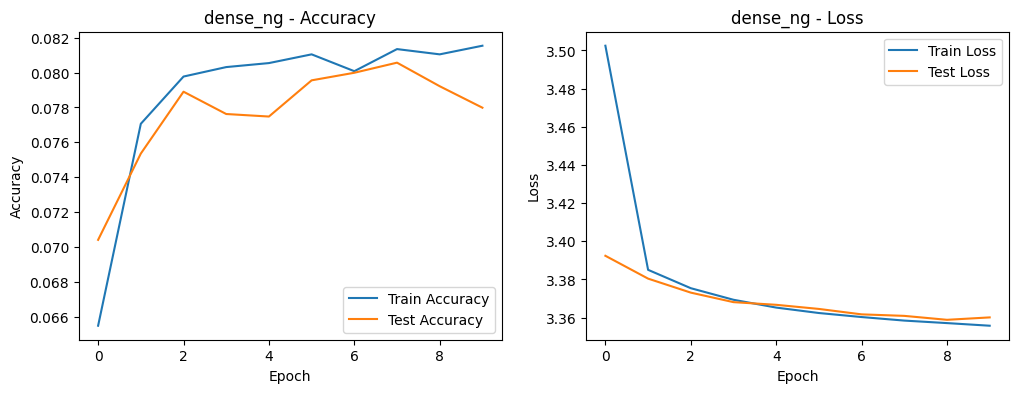

In [41]:
plot_results(dense_ng_hist, "dense_ng")

In [42]:
dense_ng.save("models/dense/ng.keras")

#### BoW

In [ ]:
dense_bow = dense_model(vocab_size)
dense_bow_hist = dense_bow.fit(
    X_train_bow, y_train_bow, epochs=20, validation_data=(X_test_bow, y_test_bow)
)

Epoch 1/10
2850/2850 ━━━━━━━━━━━━━━━━━━━━ 43s 15ms/step - accuracy: 0.0486 - loss: 4.2087 - val_accuracy: 0.0777 - val_loss: 3.5547
Epoch 2/10
2850/2850 ━━━━━━━━━━━━━━━━━━━━ 37s 13ms/step - accuracy: 0.1162 - loss: 3.4200 - val_accuracy: 0.0955 - val_loss: 3.4175
Epoch 3/10
2850/2850 ━━━━━━━━━━━━━━━━━━━━ 37s 13ms/step - accuracy: 0.1893 - loss: 3.0276 - val_accuracy: 0.1130 - val_loss: 3.3715
Epoch 4/10
2850/2850 ━━━━━━━━━━━━━━━━━━━━ 37s 13ms/step - accuracy: 0.2448 - loss: 2.7430 - val_accuracy: 0.1317 - val_loss: 3.3563
Epoch 5/10
2850/2850 ━━━━━━━━━━━━━━━━━━━━ 37s 13ms/step - accuracy: 0.2781 - loss: 2.5732 - val_accuracy: 0.1475 - val_loss: 3.3642
Epoch 6/10
2850/2850 ━━━━━━━━━━━━━━━━━━━━ 37s 13ms/step - accuracy: 0.3074 - loss: 2.4431 - val_accuracy: 0.1659 - val_loss: 3.3769
Epoch 7/10
2850/2850 ━━━━━━━━━━━━━━━━━━━━ 37s 13ms/step - accuracy: 0.3341 - loss: 2.3372 - val_accuracy: 0.1836 - val_loss: 3.3862
Epoch 8/10
2850/2850 ━━━━━━━━━━━━━━━━━━━━ 37s 13ms/step - accuracy: 0.3606 -

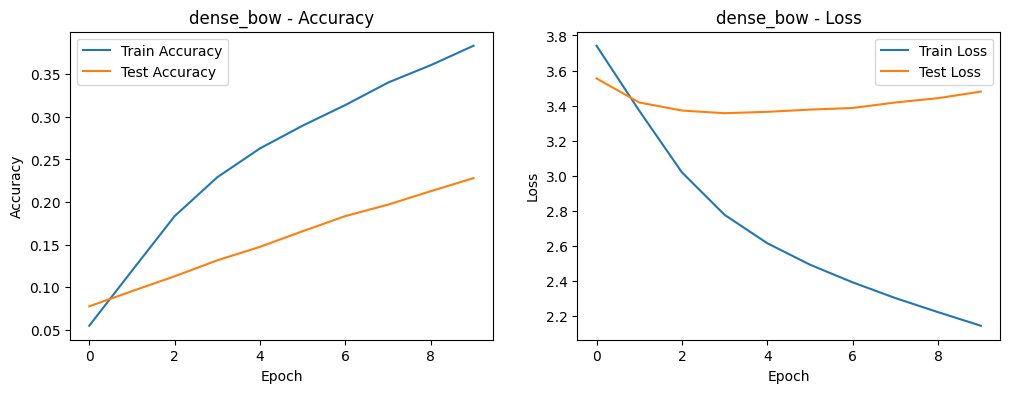

In [44]:
plot_results(dense_bow_hist, "dense_bow")

In [45]:
dense_bow.save("models/dense/bow.keras")

### RNN

#### Ngram

In [ ]:
rnn_ng = rnn_model(n_gram)
rnn_ng_hist = rnn_ng.fit(X_train_ng, y_train_ng, epochs=10, validation_data=(X_test_ng, y_test_ng))


d:\PyInterpreters\Big_data\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
5179/5179 ━━━━━━━━━━━━━━━━━━━━ 49s 9ms/step - accuracy: 0.0664 - loss: 3.6870 - val_accuracy: 0.0830 - val_loss: 3.3535
Epoch 2/10
5179/5179 ━━━━━━━━━━━━━━━━━━━━ 44s 9ms/step - accuracy: 0.0840 - loss: 3.3466 - val_accuracy: 0.0848 - val_loss: 3.3337
Epoch 3/10
5179/5179 ━━━━━━━━━━━━━━━━━━━━ 43s 8ms/step - accuracy: 0.0854 - loss: 3.3235 - val_accuracy: 0.0849 - val_loss: 3.3315
Epoch 4/10
5179/5179 ━━━━━━━━━━━━━━━━━━━━ 44s 9ms/step - accuracy: 0.0869 - loss: 3.3159 - val_accuracy: 0.0892 - val_loss: 3.3211
Epoch 5/10
5179/5179 ━━━━━━━━━━━━━━━━━━━━ 43s 8ms/step - accuracy: 0.0908 - loss: 3.3097 - val_accuracy: 0.0875 - val_loss: 3.3169
Epoch 6/10
5179/5179 ━━━━━━━━━━━━━━━━━━━━ 44s 9ms/step - accuracy: 0.0892 - loss: 3.3002 - val_accuracy: 0.0871 - val_loss: 3.3173
Epoch 7/10
5179/5179 ━━━━━━━━━━━━━━━━━━━━ 43s 8ms/step - accuracy: 0.0923 - loss: 3.2946 - val_accuracy: 0.0922 - val_loss: 3.3160
Epoch 8/10
5179/5179 ━━━━━━━━━━━━━━━━━━━━ 44s 9ms/step - accuracy: 0.0931 - loss: 3

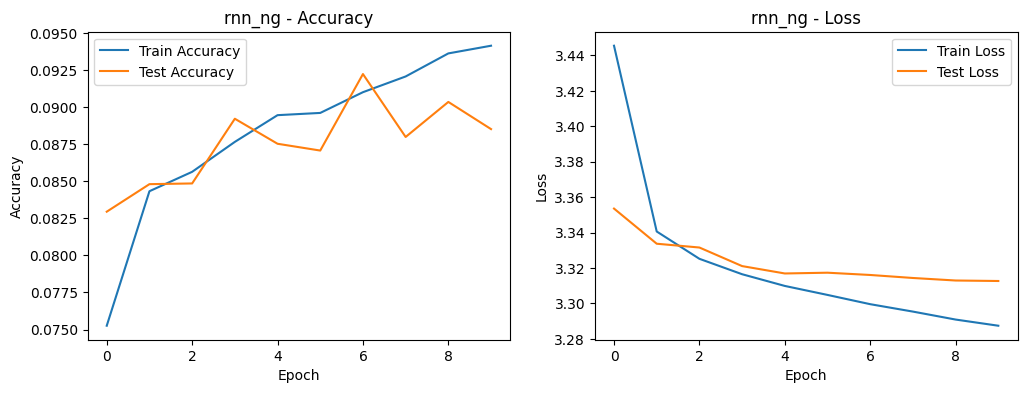

In [47]:
plot_results(rnn_ng_hist, "rnn_ng")


In [48]:
rnn_ng.save("models/rnn/ng.keras")

#### BoW

In [ ]:
rnn_bow = rnn_model(window_size)
rnn_bow_hist = rnn_bow.fit(X_train_bow, y_train_bow, epochs=10, validation_data=(X_test_bow, y_test_bow))

d:\PyInterpreters\Big_data\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
  49/2850 ━━━━━━━━━━━━━━━━━━━━ 2:15:09 3s/step - accuracy: 0.0250 - loss: 7.2126

KeyboardInterrupt: 

In [ ]:
plot_results(rnn_bow_hist, "rnn_bow")

In [ ]:
rnn_bow.save("models/rnn/bow.keras")

### GRU

#### Ngram

In [ ]:
gru_ng = gru_model(n_gram)
gru_ng_hist = gru_ng.fit(X_train_ng, y_train_ng, epochs=20, validation_data=(X_test_ng, y_test_ng))


Epoch 1/10
5179/5179 ━━━━━━━━━━━━━━━━━━━━ 51s 9ms/step - accuracy: 0.0662 - loss: 3.7177 - val_accuracy: 0.0820 - val_loss: 3.3525
Epoch 2/10
5179/5179 ━━━━━━━━━━━━━━━━━━━━ 46s 9ms/step - accuracy: 0.0849 - loss: 3.3416 - val_accuracy: 0.0900 - val_loss: 3.3249
Epoch 3/10
5179/5179 ━━━━━━━━━━━━━━━━━━━━ 47s 9ms/step - accuracy: 0.0876 - loss: 3.3118 - val_accuracy: 0.0878 - val_loss: 3.3125
Epoch 4/10
5179/5179 ━━━━━━━━━━━━━━━━━━━━ 46s 9ms/step - accuracy: 0.0908 - loss: 3.2999 - val_accuracy: 0.0895 - val_loss: 3.3057
Epoch 5/10
5179/5179 ━━━━━━━━━━━━━━━━━━━━ 50s 10ms/step - accuracy: 0.0942 - loss: 3.2810 - val_accuracy: 0.0896 - val_loss: 3.2974
Epoch 6/10
5179/5179 ━━━━━━━━━━━━━━━━━━━━ 51s 10ms/step - accuracy: 0.0987 - loss: 3.2640 - val_accuracy: 0.0957 - val_loss: 3.2887
Epoch 7/10
5179/5179 ━━━━━━━━━━━━━━━━━━━━ 48s 9ms/step - accuracy: 0.1011 - loss: 3.2522 - val_accuracy: 0.0928 - val_loss: 3.2856
Epoch 8/10
5179/5179 ━━━━━━━━━━━━━━━━━━━━ 49s 9ms/step - accuracy: 0.1066 - loss:

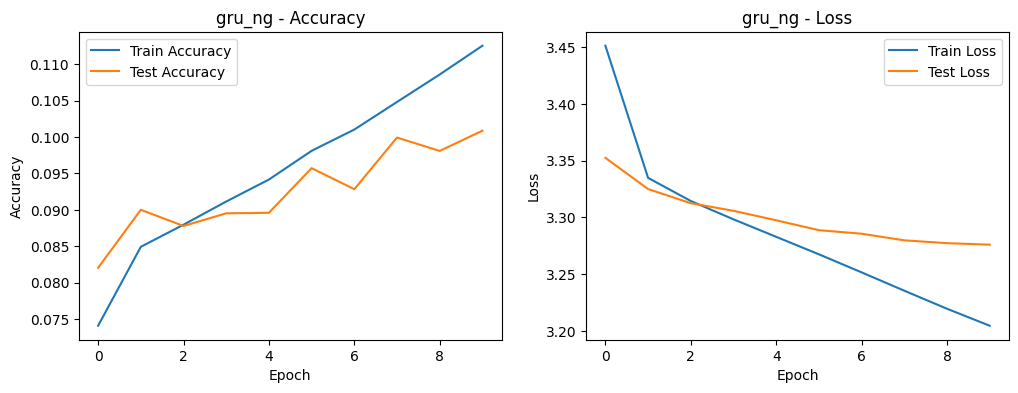

In [52]:
plot_results(gru_ng_hist, "gru_ng")


In [53]:
gru_ng.save("models/gru/ng.keras")

#### BoW

In [55]:
gru_bow = gru_model(window_size)
gru_bow_hist = gru_bow.fit(X_train_bow, y_train_bow, epochs=10, validation_data=(X_test_bow, y_test_bow))

Epoch 1/10
  10/2850 ━━━━━━━━━━━━━━━━━━━━ 3:35:13 5s/step - accuracy: 0.0250 - loss: 8.9160

KeyboardInterrupt: 

In [ ]:
plot_results(gru_bow_hist, "gru_bow")

In [ ]:
gru_bow.save("models/gru/bow.keras")

## Evaluation

In [58]:
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test).argmax(axis=1)
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    
def eval_bow(model, name):
    evaluate_model(model, X_test_bow, y_test_bow, name + "_bow")
    
def eval_ng(model, name):
    evaluate_model(model, X_test_ng, y_test_ng, name + "_ng")

In [59]:
eval_bow(dense_bow, "Dense")
# eval_bow(rnn_bow, "RNN")
# eval_bow(gru_bow, "GRU")

713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Dense_bow Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.33      0.25      1035
           1       0.17      0.28      0.21      1050
           2       0.17      0.27      0.21      1059
           3       0.30      0.10      0.15      1081
           4       0.21      0.12      0.16      1047
           5       0.21      0.16      0.18      1061
           6       0.19      0.18      0.18      1024
           7       0.18      0.19      0.19       959
           8       0.18      0.20      0.19       844
           9       0.19      0.15      0.17       854
          10       0.29      0.14      0.19       808
          11       0.16      0.25      0.20       787
          12       0.20      0.21      0.21       698
          13       0.19      0.21      0.20       679
          14       0.29      0.15      0.19       665
          15       0.18      0.23      0.20       604
      

In [60]:
eval_ng(dense_ng, "Dense")
eval_ng(rnn_ng, "RNN")
eval_ng(gru_ng, "GRU")

1295/1295 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

Dense_ng Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.58      0.19      2533
           1       0.13      0.08      0.10      2549
           2       0.14      0.04      0.06      2489
           3       0.08      0.35      0.13      2581
           4       0.00      0.00      0.00      2289
           5       0.00      0.00      0.00      2052
           6       0.05      0.10      0.06      1891
           7       0.04      0.05      0.04      1807
           8       0.05      0.01      0.02      1580
           9       0.00      0.00      0.00      1559
          10       0.04      0.02      0.02      1363
          11       0.06      0.00      0.00      1295
          12       0.00      0.00      0.00      1190
          13       0.03      0.10      0.05      1149
          14       0.00      0.00      0.00      1016
          15       0.00      0.00      0.00       997
     

# Word prediction

In [133]:
def predict_next_word(
    model, input_sequence, word_to_idx, idx_to_word, mode="ngram", top_k=3
):
    """
    Предсказывает следующее слово на основе входной последовательности.

    Параметры:
        model: обученная модель (Keras или sklearn).
        input_sequence: исходное предложение (строка).
        word_to_idx: словарь для преобразования слов в индексы.
        idx_to_word: словарь для преобразования индексов в слова.
        mode: тип модели ("ngram" или "bow").
        top_k: количество вариантов для вывода.
    """
    # Токенизация и преобразование в нижний регистр
    tokens = word_tokenize(input_sequence.lower())
    tokens_idx = [
        word_to_idx.get(word, -1) for word in tokens
    ]  # -1 для неизвестных слов

    # Обработка неизвестных слов (замена на <UNK> или пропуск)
    tokens_idx = [
        idx if idx != -1 else word_to_idx.get("<UNK>", -1) for idx in tokens_idx
    ]
    if -1 in tokens_idx:
        print("Есть неизвестные слова!")
        return []

    # Подготовка данных в зависимости от типа модели
    if mode == "bow":
        # Используем последние window_size слов как контекст
        # window_size = 5  # Должно совпадать с обучением!
        context = tokens_idx[-window_size:]
        if len(context) < window_size:
            # Дополняем нулями слева (pad_sequences)
            context = [0] * (window_size - len(context)) + context

        # Создаем вектор BoW (количество вхождений каждого слова)
        bow_vector = np.zeros(len(word_to_idx))
        for idx in context:
            if idx < len(word_to_idx):
                bow_vector[idx] += 1
        input_data = bow_vector.reshape(1, -1)

    elif mode == "ngram":
        # Используем последние n-1 слов для N-граммной модели
        # n_gram = 3  # Должно совпадать с обучением!
        seq_length = n_gram - 1
        context = tokens_idx[-seq_length:]
        if len(context) < seq_length:
            # Дополняем нулями слева
            context = [0] * (seq_length - len(context)) + context

        input_data = np.array([context])

    else:
        raise ValueError("Режим должен быть 'bow' или 'ngram'")

    # Предсказание
    preds = model.predict(input_data)[0]
    top_indices = preds.argsort()[-top_k:][::-1]  # Топ-K индексов
    top_words = [idx_to_word[idx] for idx in top_indices if idx in idx_to_word]

    return top_words

In [153]:
def generate_text(
    model, 
    seed_text, 
    word_to_idx, 
    idx_to_word, 
    mode="ngram", 
    num_words=5, 
    temperature=1.0, 
    top_k=5
):
    """
    Генерирует последовательность слов на основе начального текста.
    
    Параметры:
        model: обученная модель
        seed_text: начальный текст (строка)
        word_to_idx: словарь слово -> индекс
        idx_to_word: словарь индекс -> слово
        mode: "ngram" (RNN/GRU) или "bow"
        num_words: количество слов для генерации
        temperature: уровень случайности (0.1-2.0)
        top_k: выбор из топ-K вероятных слов
    """
    generated = seed_text.split()
    tokens = word_tokenize(seed_text.lower())
    tokens_idx = [word_to_idx.get(word, word_to_idx.get("<UNK>", 0)) for word in tokens]

    for _ in range(num_words):
        # Подготовка входных данных
        if mode == "bow":
            # window_size = 5
            context = tokens_idx[-window_size:]
            if len(context) < window_size:
                context = [0] * (window_size - len(context)) + context
            
            bow_vector = np.zeros(len(word_to_idx))
            for idx in context:
                bow_vector[idx] += 1
            input_data = bow_vector.reshape(1, -1)
            
        elif mode == "ngram":
            # n_gram = 3
            seq_length = n_gram - 1
            context = tokens_idx[-seq_length:]
            if len(context) < seq_length:
                context = [0] * (seq_length - len(context)) + context
            input_data = np.array([context])
        
        # Предсказание
        preds = model.predict(input_data, verbose=0)[0]
        preds = np.log(preds) / temperature  # Применяем температуру
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        
        # Выбор из топ-K слов
        top_indices = np.argpartition(preds, -top_k)[-top_k:]
        top_probs = preds[top_indices]
        top_probs = top_probs / np.sum(top_probs)  # Нормализуем
        
        # Сэмплирование
        chosen_idx = np.random.choice(top_indices, p=top_probs)
        chosen_word = idx_to_word.get(chosen_idx, "<UNK>")
        
        # Обновляем контекст
        generated.append(chosen_word)
        tokens_idx.append(chosen_idx)

    return generated

In [157]:
input_sentence = "love this model"
idx_to_word = {v: k for k, v in global_word_to_idx.items()}  # Создаем обратный словарь

# Предсказание через BoW
bow_prediction = generate_text(
    dense_bow, input_sentence, global_word_to_idx, idx_to_word, mode="bow", top_k=3
)
" ".join(bow_prediction)

'love this model buyed branded buyed 47260 usp'

In [158]:
input_sentence = "love this model"
idx_to_word = {v: k for k, v in global_word_to_idx.items()}  # Создаем обратный словарь

# Предсказание через BoW
bow_prediction = generate_text(
    rnn_ng, input_sentence, global_word_to_idx, idx_to_word, mode="ngram", top_k=3
)
" ".join(bow_prediction)

'love this model gb circuiy refundable claims 47260'